# Evolutionary Strategies

<a rel="license" href="http://creativecommons.org/licenses/by-sa/4.0/"><img alt="Creative Commons License" align="left" src="https://i.creativecommons.org/l/by-sa/4.0/80x15.png" /></a>&nbsp;| Dennis G. Wilson | <a href="https://rl-vs.github.io/rlvs2021/">https://rl-vs.github.io/rlvs2021/</a>

# The $(1 + \lambda)$ ES

The simplest Evolutionary Strategy is the $(1+1)$. In this algorithm, the best individual generated is replaced by a new individual when its **fitness** is superior to the current best.

    Initialize x randomly in ℝ
    while not terminate
        x' = x + 𝑁(0, 1)
        if f(x′) < f(x)
            x = x'
    return x

In this algorithm, at each step, we randomly sample from a Normal distribution to get one new point near the current point. What if, instead of sampling one point, we sampled multiple points? We'll first look at examples of continuous functions, as their search space is easier to visualize.

In [1]:
def himmelblau(x, y):
    return (x**2 + y - 11)**2 + (x + y**2 - 7)**2

In [2]:
%matplotlib inline
import matplotlib.pyplot as plt
from matplotlib import ticker, cm
import matplotlib.colors as colors
import numpy as np
import math

In [3]:
X = np.arange(-5, 5, 0.1)
Y = np.arange(-5, 5, 0.1)
X, Y = np.meshgrid(X, Y)
Z = himmelblau(X, Y)

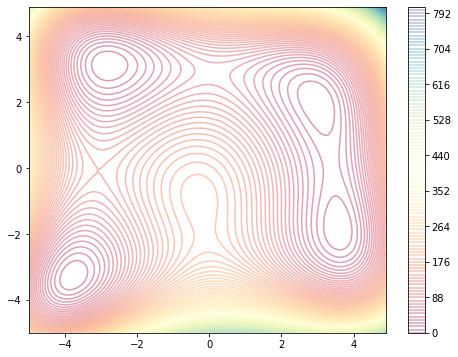

In [4]:
fig = plt.figure(figsize=(8, 6))
cs = plt.contour(X, Y, Z, levels=100, cmap='Spectral',
                 norm=colors.Normalize(vmin=Z.min(), vmax=Z.max()), alpha=0.4)
fig.colorbar(cs)
plt.show()

We'll start with a random point $x$. We'll then use a Normal distribution to draw points around $x$, this time generating 20 points around $x$ instead of 1.

In [5]:
x = np.random.rand(2) * 4 - 2
print("position: ", x, "fitness :", himmelblau(x[0], x[1]))

position:  [-0.48013222  0.75247568] fitness : 148.14242337326


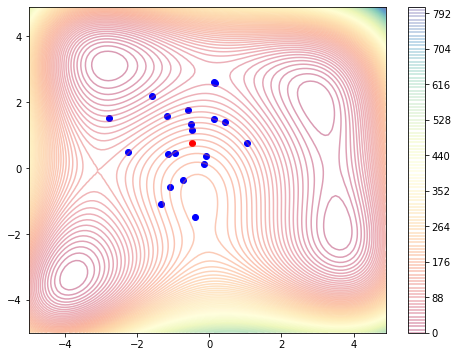

In [6]:
x_t = np.array([x + np.random.normal(size=(2,)) for i in range(20)])
fig = plt.figure(figsize=(8, 6))
cs = plt.contour(X, Y, Z, levels=100, cmap='Spectral',
                 norm=colors.Normalize(vmin=Z.min(), vmax=Z.max()), alpha=0.4)
plt.scatter(x_t[:, 0], x_t[:, 1], c='b')
plt.scatter(x[0], x[1], c='r')
fig.colorbar(cs)
plt.show()

Having this population of points will enable us to explore the space around $x$ before moving on to the next step, which can better inform movement in the search space. However, these points might overlap or cover spaces that have already been explored. Generating too many points could slow down search, requiring more evaluations of the objective function. In many applications, that is costly.

Performing random optimization but sampling more than 1 point leads to the $(1+\lambda)$ Evolutionary Strategy. 

    Initialize x randomly in ℝ
    while not terminate
        x_p = x
        for i in [1,λ]
            x_i = x_p + 𝑁(0, 1)
            if f(x_i) < f(x)
                x = x_i
        x_p = x
    return x_p

In the scope of evolutionary algorithms, we'll refer to $x$ as a parent and all $x'$ points as offspring. Each point can also be referred to as an individual in a population, and $f(x)$ is called the fitness of the individual. Each iteration of the algorithm is called a generation.

The $(\mu/\rho,\lambda)$ or $(\mu/\rho+\lambda)$ notation signifies the configuration of parents and offspring. In this notation, $\mu$ is the number of parents, $\rho$ is the number of parents involved in creating the offspring, and $\lambda$ is the number of offspring. $(\mu/\rho+\lambda)$ means the parents can be included in the next population, whereas $(\mu/\rho,\lambda)$ means the parents are not included. $(1+\lambda)$ therefore means that 1 parent is involved in creating a population of $\lambda$ offspring and can be included in the next generation (ie, if $f(x) < f(x') \forall x'$, $x$ does not change).

In [39]:
def oneplus_lambda(x, fitness, gens=100, lam=20):
    x_best = x
    f_best = fitness(x)
    fits = np.zeros(gens)
    for g in range(gens):
        N = np.random.normal(size=(lam, len(x)))
        for i in range(lam):
            ind = x + N[i, :]
            f = fitness(ind)
            if f < f_best:
                f_best = f
                x_best = ind
        x = x_best
        fits[g] = f_best
    return fits

In [40]:
x = np.random.rand(2)*10-5
fitness = lambda x : himmelblau(x[0], x[1])

In [41]:
fits = oneplus_lambda(x, fitness)
(fits[0], fits[-1])

(3.2759949011034135, 0.0026712594447843773)

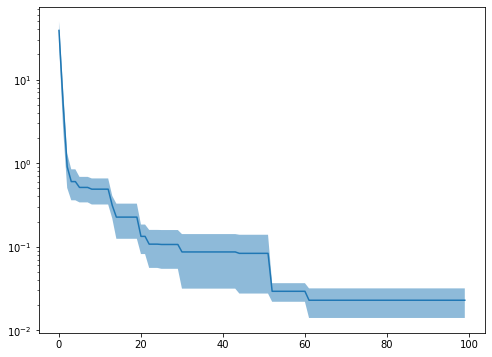

In [42]:
fig = plt.figure(figsize=(8, 6))
runs = []
ax_x = range(100)
for i in range(5):
    x = np.random.rand(2)*10-5
    runs += [oneplus_lambda(x, fitness)]
runs = np.array(runs)
runs_mean = np.mean(runs, 0)
runs_std = np.std(runs, 0)
plt.fill_between(range(len(runs[0])), runs_mean+0.5*runs_std, runs_mean-0.5*runs_std, alpha=0.5)
plt.plot(range(len(runs[0])), runs_mean)
plt.yscale('log')

## Approximating the gradient

In the $(1+\lambda)$ ES, we move from the best point in a population to the best point in the next randomly sampled population. However, with the population information, we can do better than that; we can move in the direction of the gradient approximated by the fitness values of the population. This can also better use the full population information, combining all fitness information instead of selecting the best fitness value.

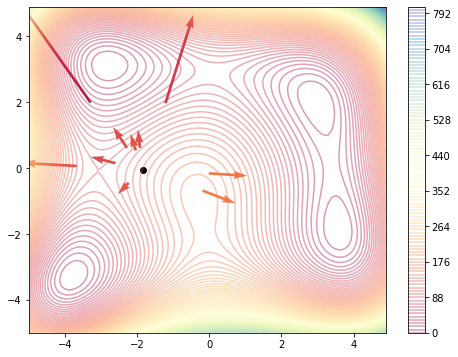

In [43]:
x_t = np.array([x + np.random.normal(size=(2,)) for i in range(10)])
fits = himmelblau(x_t[:, 0], x_t[:, 1])

fig = plt.figure(figsize=(8, 6))
norm = colors.Normalize(vmin=Z.min(), vmax=Z.max())
cs = plt.contour(X, Y, Z, levels=100, cmap='Spectral', alpha=0.4, norm=norm)
plt.quiver(x_t[:, 0], x_t[:, 1], x_t[:, 0]-x[0], x_t[:, 1]-x[1],
           fits, scale=fits/100, scale_units='xy', cmap='Spectral', norm=norm)
plt.scatter(x[0], x[1], c='k')
fig.colorbar(cs)
plt.show()

First we normalize all fitness values by the average $\mu(f(x))$ and standard deviation $\sigma(f(x))$ of the population. This is to make the movement based on the relative fitness in the population as opposed to the absolute fitness in the search space.

$A = \frac{f(x) - \mu(f(x))}{\sigma(f(x))}$

We'll then define a vector at each point, $x_i - x$. Note that since $x_i = x + N(0, 1)$, we could store just this original random sampled point from $N(0, 1)$ as our vector.

$N_i = x_i - x$

We multiply $A$ by all individual vectors which scales the vector magnitude by the relative fitness. Finally, we sum all vectors and divide by $\lambda$ to get the weighted average.

$\frac{1}{\lambda}\sum_i A_i N_i$

This is equivalent to the dot product and is used as our gradient approximation. Since we're minimizing, we'll use the negative value to do gradient descent.

$\nabla f \approx -\frac{A \cdot N}{\lambda}$

In [44]:
A = (fits - np.mean(fits)) / np.std(fits)
N = x_t - x
G = -np.dot(A, N) / 10

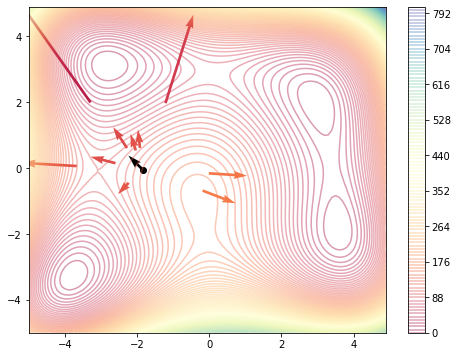

In [45]:
fig = plt.figure(figsize=(8, 6))
norm = colors.Normalize(vmin=Z.min(), vmax=Z.max())
cs = plt.contour(X, Y, Z, levels=100, cmap='Spectral', alpha=0.4, norm=norm)
plt.quiver(x_t[:, 0], x_t[:, 1], x_t[:, 0]-x[0], x_t[:, 1]-x[1],
           fits, scale=fits/100, scale_units='xy', cmap='Spectral', norm=norm)
plt.quiver(x[0], x[1], G[0], G[1])
plt.scatter(x[0], x[1], c='k')
fig.colorbar(cs)
plt.show()

We have our approximate gradient direction, but how far should we move in it? We'll define a learning rate variable $\alpha$ as the fixed magnitude of movement for now, so our update of $x$ is then

$x = x - \alpha\frac{A \cdot N}{\lambda}$

Let's put this all together as an Evolutionary Strategy. It is a $(\mu, \lambda)$ ES as multiple individuals $\mu$ inform the next generation; however, these individuals are not kept for the next generation.

    Initialize x randomly in ℝ
    x_best = x
    while not terminate
        for i in [1,λ]
            N_i = 𝑁(0, 1)
            F_i = f(x + N_i)
            if F_i < f(x_best)
                x_best = x + N_i
        A = (F−𝜇(F))/𝜎(F)
        x = x - 𝛼(A⋅N)/𝜆
    return x_best

In [46]:
def mu_lambda(x, fitness, gens=100, lam=10, alpha=0.1, verbose=False):
    x_best = x
    f_best = fitness(x)
    fits = np.zeros(gens)
    for g in range(gens):
        N = np.random.normal(size=(lam, len(x)))
        F = np.zeros(lam)
        for i in range(lam):
            ind = x + N[i, :]
            F[i] = fitness(ind)
            if F[i] < f_best:
                f_best = F[i]
                x_best = ind
                if verbose:
                    print(g, " ", f_best)
        fits[g] = f_best
        mu_f = np.mean(F)
        std_f = np.std(F)
        A = F
        if std_f != 0:
            A = (F - mu_f) / std_f
        x = x - alpha * np.dot(A, N) / lam
    return fits, x_best

In [47]:
x = np.random.rand(2)*10-5

In [48]:
fitness = lambda x : himmelblau(x[0], x[1])

In [49]:
fits_mu, _ = mu_lambda(x, fitness)

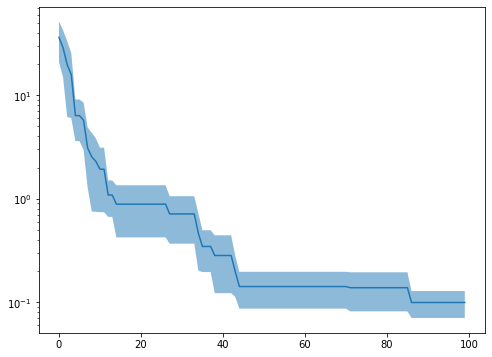

In [50]:
fig = plt.figure(figsize=(8, 6))
runs = []
ax_x = range(100)
for i in range(5):
    x = np.random.rand(2)*10-5
    fits, _ = mu_lambda(x, fitness)
    runs += [fits]
runs = np.array(runs)
runs_mean = np.mean(runs, 0)
runs_std = np.std(runs, 0)
plt.fill_between(range(len(runs[0])), runs_mean+0.5*runs_std, runs_mean-0.5*runs_std, alpha=0.5)
plt.plot(range(len(runs[0])), runs_mean)
plt.yscale('log')

## Beyond functions: Neuroevolution

In [51]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.multiprocessing as mp
import gym

In [52]:
class NeuralNetwork(nn.Module):

    def __init__(self, input_shape, n_actions):
        super(NeuralNetwork, self).__init__()
        self.l1 = nn.Linear(input_shape, 32)
        self.l2 = nn.Linear(32, 32)
        self.lout = nn.Linear(32, n_actions)
        
    def forward(self, x):
        x = F.relu(self.l1(x.float()))
        x = F.relu(self.l2(x))
        return self.lout(x)
    
    def get_params(self):
        p = np.empty((0,))
        for n in self.parameters():
            p = np.append(p, n.flatten().cpu().detach().numpy())
        return p
    
    def set_params(self, x):
        start = 0
        for p in self.parameters():
            e = start + np.prod(p.shape)
            p.data = torch.FloatTensor(x[start:e]).reshape(p.shape)
            start = e

We'll add some visualization functionality to have the environment render directly in the notebook. To run this notebook in Google colab, uncomment and run the following lines.

In [53]:
#!apt-get install -y xvfb python-opengl > /dev/null 2>&1

In [54]:
#!pip install pyvirtualdisplay

In [55]:
from pyvirtualdisplay import Display
from IPython import display
import matplotlib.pyplot as plt
%matplotlib inline
pydisplay = Display(visible=0, size=(1400, 900))
pydisplay.start()
plt.ion();

In [56]:
def evaluate(ann, env, visul=True):
    env.seed(0)
    obs = env.reset()
    if visul:
        img = plt.imshow(env.render(mode='rgb_array'))
    total_reward = 0
    while True:
        # Output of the neural net
        net_output = ann(torch.tensor(obs))
        # the action is the value clipped returned by the nn
        action = net_output.data.cpu().numpy().argmax()
        obs, reward, done, _ = env.step(action)
        total_reward += reward
        if visul:
            img.set_data(env.render(mode='rgb_array')) 
            plt.axis('off')
            display.display(plt.gcf())
            display.clear_output(wait=True)
        if done:
            break
    return total_reward

We've configured this for discrete action spaces. We can see a random neural network on different environments like `CartPole-v0`, `MountainCar-v0`, and `LunarLander-v2`.

In [57]:
env = gym.make('LunarLander-v2')
ann = NeuralNetwork(env.observation_space.shape[0], env.action_space.n)

In [58]:
evaluate(ann, env, visul=False)

-1245.4455256553836

In order to evolve the parameters of this neural network, we 

In [59]:
p = ann.get_params()
np.shape(p)

(1476,)

In [60]:
x = np.random.rand(len(p))

In [61]:
def fitness(x, visul=False):
    env = gym.make('CartPole-v0')
    ann = NeuralNetwork(env.observation_space.shape[0], env.action_space.n)
    ann.set_params(x)
    return -evaluate(ann, env, visul=visul)

In [62]:
fitness(x)

-9.0

In [66]:
env = gym.make('CartPole-v0')
ann = NeuralNetwork(env.observation_space.shape[0], env.action_space.n)
x = ann.get_params()
fits, x = mu_lambda(x, fitness, gens=100, lam=10, alpha=0.1, verbose=True)

0   -14.0
0   -32.0
1   -35.0
2   -38.0
3   -72.0
5   -83.0
7   -200.0


-200.0

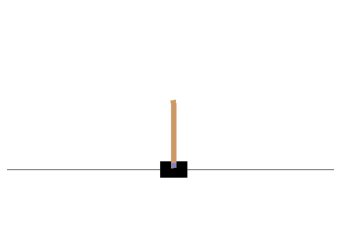

In [36]:
fitness(x, visul=True)